In [1]:
%matplotlib inline
from main import *

In [2]:
class fake_args_parser(object):
    def __init__(self):
        super(fake_args_parser, self).__init__()
        self.env = ENV
        self.capacity = CAPACITY
        self.num_episode = NUM_EPISODE
        self.batch_size = BATCH_SIZE
        self.gamma = GAMMA
        self.init_eps = INIT_EPS
        self.init_lr = INIT_LR
        self.end_eps = END_EPS
        self.eps_decay = EPS_DECAY

args = fake_args_parser()

In [3]:
def cmain(args):
    print('Playing {}'.format(args.env))
    env = gym.make(args.env).unwrapped

    agent = SimpleAgent(env.observation_space, env.action_space, args.init_eps,
                  args.end_eps, args.eps_decay)
    agent_optimizer = DQN_Optimizer(
        agent, args.gamma, args.capacity, args.batch_size, args.init_lr)

    visualizer = Visualizer()
    visualizer.register('episode_length', 'episode', 'episode_length')
    visualizer.register('average_loss', 'episode', 'average_loss')
    visualizer.register('evaluation_length', 'episode *100', 'evaluation_length')
    visualizer.register('epsilon', 'episode', 'epsilon')

    for episode in range(args.num_episode):
        state = env.reset()

        running_loss = 0.
        for step in count():
            action = agent.e_greedy_act(state)
            # action = agent.boltzmann_act(state)

            next_state, reward, done, _ = env.step(action)
            # env.render()

            if done:
                next_state = None
            agent_optimizer.memory.push_back(
                    SARS(state, action, reward, next_state))

            if agent_optimizer.memory.trainable:
                loss = agent_optimizer.step()
                running_loss += loss

            state = next_state

            if done:
                # print('[Train] {}th episode ends at {} time step. Its average loss is {:.4f}, running loss is {:.4f}'.format(
                    # episode, step, running_loss/step, running_loss))
                visualizer.push_back(episode_length=step, average_loss=running_loss/step, epsilon=agent.eps)
                break

        if episode % 100 == 99:
            total_reward = 0.

            for eval in range(NUM_TEST):
                state = env.reset()
                
                for step in count():
                    # evaluating agent greedily
                    action = agent.greedy_act(state)

                    next_state, reward, done, _ = env.step(action)
#                     env.render()

                    state = next_state
                    total_reward += reward

                    if done:
                        break
            print('[Eval] {}th episode, total reward: {}, average reward: {}'.format(episode, total_reward, total_reward/NUM_TEST))
            visualizer.push_back(evaluation_length=total_reward/NUM_TEST)
    visualizer.save()

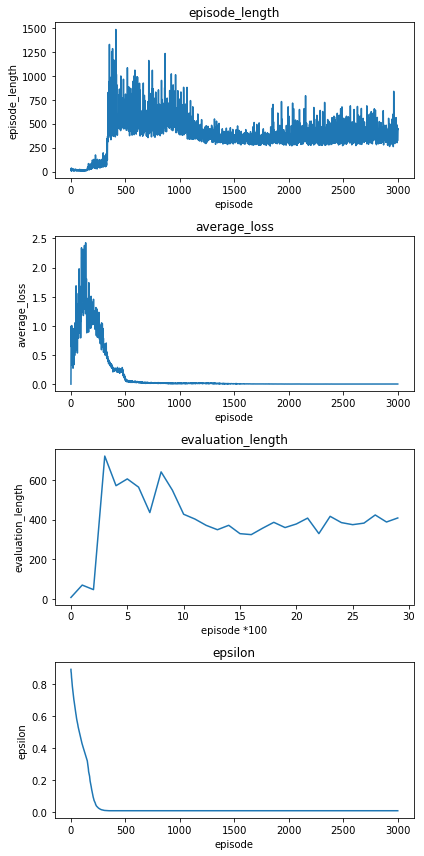

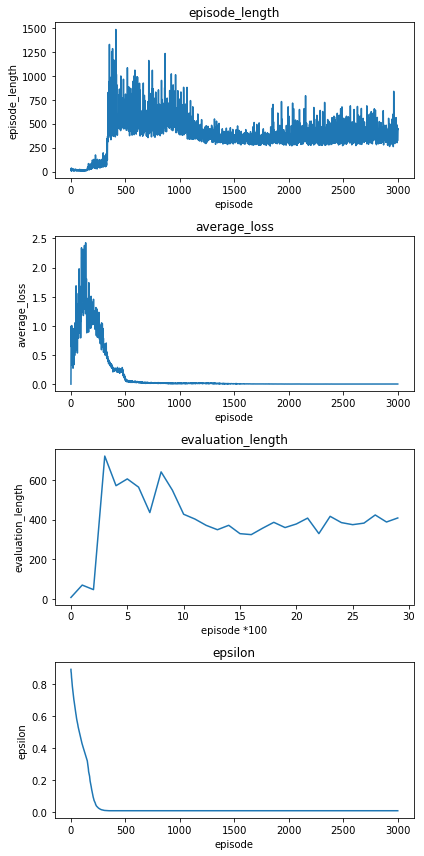

In [4]:
cmain(args)